In [1]:
%load_ext autoreload
%autoreload 2

# Introduction and Objective
## Training with MultiTask Learning

In [2]:
import h5py
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

In [3]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
from utils import HDF5MultitaskDataset, ResizeAndLandmarksTransform

# load parameters

In [5]:
with open("../../code_configs/params.yaml") as f:
    params = yaml.safe_load(f)

In [6]:
print(params)

{'RAW_DATA_DIRECTORY': '../../data/raw', 'INTERMEDIATE_DATA_DIRECTORY': '../../data/intermediate', 'PRIMARY_DATA_DIRECTORY': '../../data/primary', 'DATASET_1_RAW_ZIP_FILE_NAME': 'radiography-20221212T190109Z-001.zip', 'DATASET_1_RAW_ZIP_NEW_ANNOT_FILE_NAME': 'label_edited-20230122T143005Z-001.zip', 'DATASET_1_INTERMEDIATE_DIR_NAME': 'dataset_1', 'DATASET_1_UNWANTED_JSON_FIELDS': ['imageData'], 'DATASET_3_RAW_RAR_FILE_NAME': 'RawImage.rar', 'DATASET_3_RAW_DIR_NAME_TEMP': 'dataset_3_bmp', 'DATASET_3_RAW_DIR_NAME': 'dataset_3_raw_data', 'UNWANTED_JSON_FIELDS': ['imageData', 'imagePath'], 'DATASET_1_INTERM_DIR_NAME': 'dataset_1_interm_data-20230304T160341Z-001', 'DATASET_1_INTERM_IMG_DIR_NAME': ['image'], 'DATASET_1_INTERM_V_LANDMARKS_DIR_NAME': ['label'], 'DATASET_1_INTERM_F_LANDMARKS_DIR_NAME': None, 'DATASET_2_INTERM_DIR_NAME': 'dataset_2_interm_data-20230304T160421Z-001', 'DATASET_2_INTERM_IMG_DIR_NAME': ['image'], 'DATASET_2_INTERM_V_LANDMARKS_DIR_NAME': ['label'], 'DATASET_2_INTERM_F

# Load metadata table

In [7]:
metadata_table = pd.read_hdf(
    os.path.join(params['PRIMARY_DATA_DIRECTORY'], params['METADATA_TABLE_NAME']),
    key='df',
)

In [8]:
metadata_table.head(2)

,source_image_filename,harmonized_id,dataset,dev_set,v_annots_present,f_annots_present,split
0,45.jpg,71657ae53721e50ca772d387bd284b4dd58247893bdf4a...,dataset_1,NaN,True,False,undefined
1,92.jpg,9b252d975480242e836e274ae0e6204e84a7f0f524666c...,dataset_1,NaN,True,False,undefined


### compute statistics of the v_annots and f_annots

In [9]:
display(metadata_table.groupby('split').apply(lambda x: x.loc[:,['v_annots_present', 'f_annots_present']].describe()))

v_annots_present f_annots_present
split                                             
test      count                97               97
          unique                2                2
          top                True             True
          freq                 89               80
train     count               287              287
          unique                2                2
          top                True             True
          freq                263              240
undefined count               142              142
          unique                2                1
          top                True            False
          freq                140              142
val       count                95               95
          unique                2                2
          top                True             True
          freq                 86               80

# training set torch dataset

In [10]:
train_file_list = metadata_table.loc[metadata_table['split']=='train', ['harmonized_id']].to_numpy().ravel().tolist()

In [11]:
train_file_list = [os.path.join(params['PRIMARY_DATA_DIRECTORY'], file_path+'.hdf5') for file_path in train_file_list]

In [29]:
my_transforms = transforms.Compose([
    ResizeAndLandmarksTransform(tuple(params['TARGET_IMAGE_SIZE'])),
])

In [30]:
# Example usage
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    transforms=my_transforms,
)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [31]:
iterator = iter(train_dataset)
samples = []
v_shapes = []
for i, sample in enumerate(iterator):
    samples.append(sample)
    print()
    #print(i)
    if sample['v_landmarks'] is not None:
        print(sample['v_landmarks'].shape[0])
        v_shapes.append(sample['v_landmarks'].shape)
    else:
        print("V_landmarks are None!")
    if i == 10:
        break


V_landmarks are None!

13

13

13

13

13

13

13

13

V_landmarks are None!

13


In [27]:
for sample in samples:
    print(type(sample['image']))
    print("image: ", sample['image'].shape)
    print(type(sample['v_landmarks']))
    if sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

<class 'numpy.ndarray'>
image:  (2600, 1684, 3)
<class 'NoneType'>

<class 'numpy.ndarray'>
image:  (1940, 1255)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (1940, 1256)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (1940, 1255)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (2608, 1692, 3)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (2600, 1696, 3)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (2600, 1696, 3)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (2596, 1688, 3)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (1940, 1256)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)

<class 'numpy.ndarray'>
image:  (1940, 1255)
<class 'NoneType'>

<class 'numpy.ndarray'>
image:  (2608, 1688, 3)
<class 'numpy.ndarray'>
v_landmarks:  (13, 2)



In [40]:
def plot_image_landmarks(
    image,
    v_landmarks,
    f_landmarks,
):
    fig, ax = plt.subplots(figsize=(5,5),)
    ax.imshow(image, cmap='gray')
    # Plot points on top of image
    if v_landmarks is not None:
        for i in range(v_landmarks.shape[0]):
            ax.scatter(v_landmarks[i,0], v_landmarks[i,1], color='red', s=10)
    if f_landmarks is not None:
        for i in range(f_landmarks.shape[0]):
            ax.scatter(f_landmarks[i,0], f_landmarks[i,1], color='orange', s=10)
    # set the ticker
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    # get the current tick locations and labels
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()

    # set the rotation angle for the tick labels
    ax.set_xticklabels(xticks, rotation=45)

    # Show plot
    plt.show()

/tmp/ipykernel_5614/2491208439.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=45)


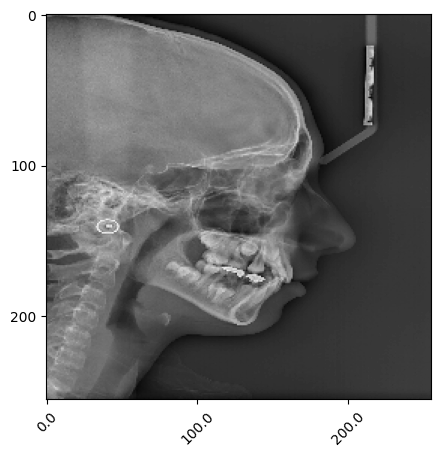

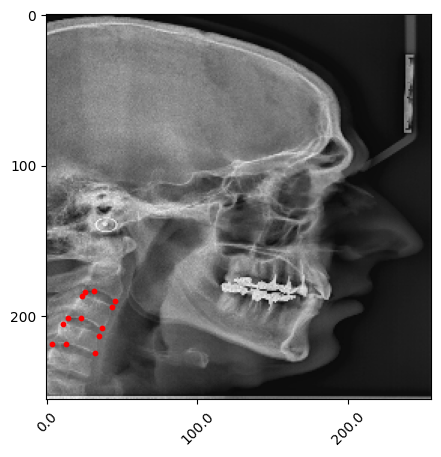

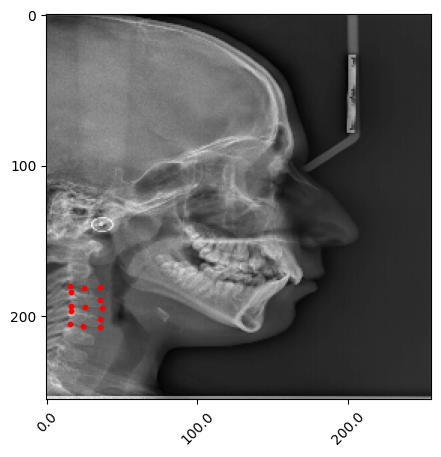

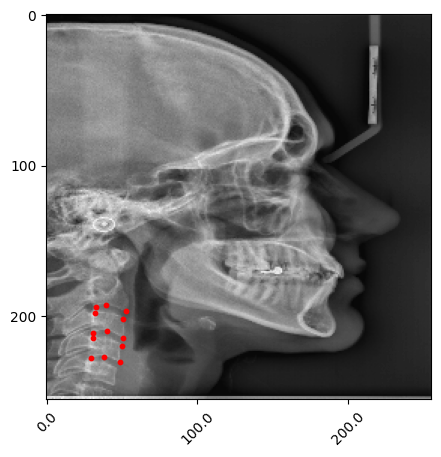

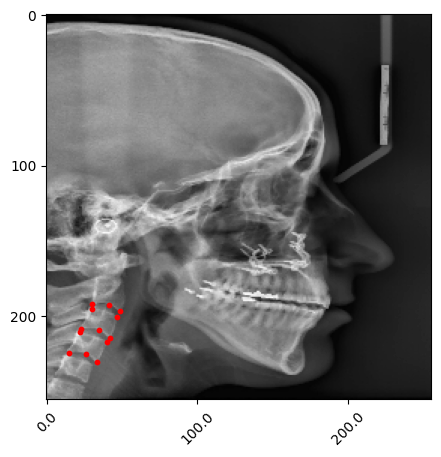

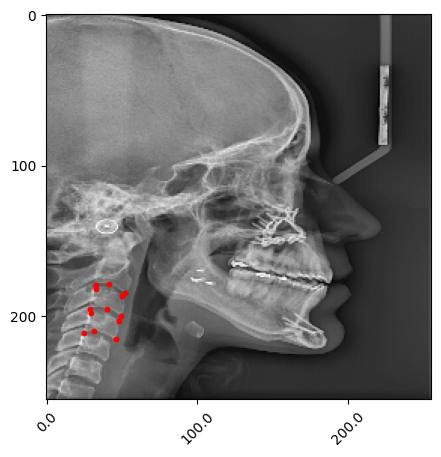

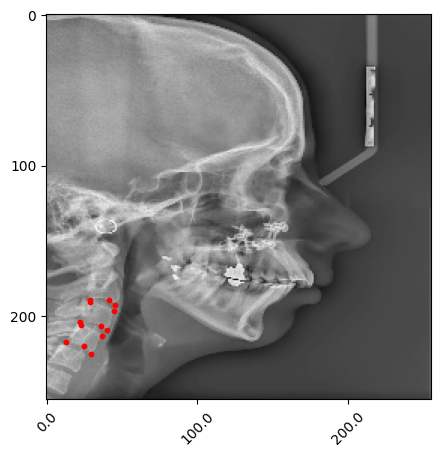

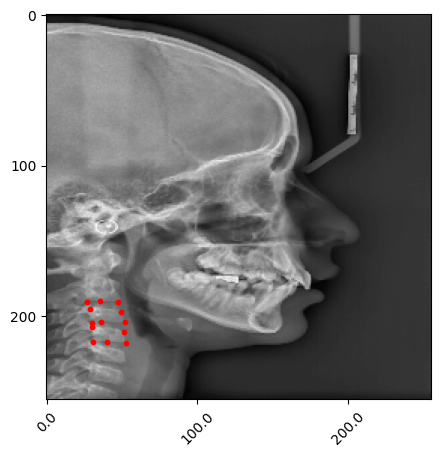

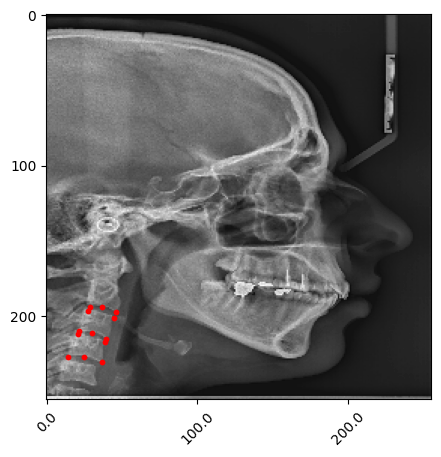

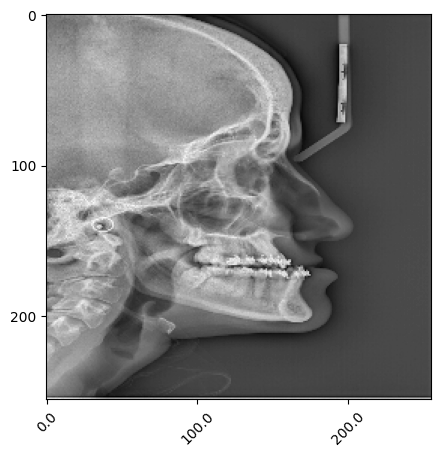

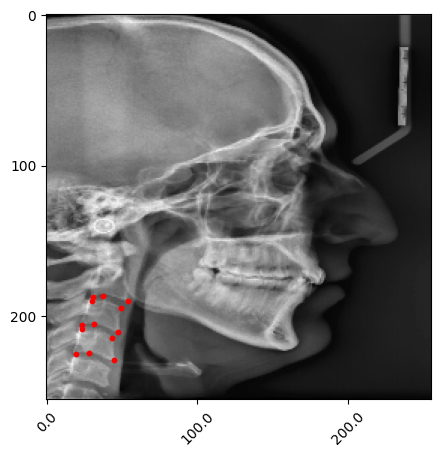

In [41]:
for sample in samples:
    v_landmarks = sample['v_landmarks']
    f_landmarks = sample['f_landmarks']
    image = sample['image'][0,...]

    plot_image_landmarks(
        image,
        v_landmarks,
        f_landmarks,
    )
    print()

In [43]:
# sanity check the dataset and dataloader
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

TypeError: expected Tensor as element 6 in argument 0, but got NoneType